In [18]:
import pandas as pd
import matplotlib.pyplot as plt

## 参数与氪金档位配置

In [31]:
# 模拟总天数（约 6 个月 = 182 天）
DAYS = 182

# 各项收益值（“价值”，美金等价计）
NEW_PLAYER_BONUS   = 50    # 新手奖励（仅第1天领取一次）
DAILY_FREE         = 10    # 每日免费获得
WEEKLY_FREE_VAL    = 10    # 每周活动白嫖价值
SPECIAL_EVENT_VAL  = 150   # 特惠活动价值（每周一次）
DAILY_LIMIT_VAL    = 100   # 每次每日限购价值

# 通行证价值（每月可获得的“价值”，美金等价计）
PASS_SMALL_VALUE   = 30    # 小通行证一个月可获得的价值
PASS_BIG_VALUE     = 90    # 大通行证一个月可获得的价值

# 通行证价格（每月实际售价，美元）
PASS_SMALL_PRICE   = 4.99  # 小通行证价格
PASS_BIG_PRICE     = 19.99 # 大通行证价格

# 特惠活动与每日限购的实际价格
SPECIAL_EVENT_PRICE = 12    # 每次特惠活动售价（美元）
DAILY_LIMIT_PRICE   = 2.99  # 每次每日限购售价（美元）

## 各档玩家参与配置

In [32]:
# 字段说明：
#   new_player             是否领取新手奖励
#   daily_free             是否每日免费领取
#   weekly_free            是否参与每周白嫖
#   special_events_per_week 每周参加多少次特惠活动
#   daily_limit_times      每天可购买多少次限购（0-5）
#   small_pass             是否购买小通行证（每月）
#   big_pass               是否购买大通行证（每月）

# 根据实际需求，可以自行修改下列配置：
TIERS = {
    "零氪": {
        "new_player": True,
        "daily_free": True,
        "weekly_free": True,
        "special_events_per_week": 0,
        "daily_limit_times": 0,
        "small_pass": False,
        "big_pass": False
    },
    "微氪": {
        "new_player": True,
        "daily_free": True,
        "weekly_free": True,
        "special_events_per_week": 0,
        "daily_limit_times": 0,
        "small_pass": True,
        "big_pass": False
    },
    "中氪": {
        "new_player": True,
        "daily_free": True,
        "weekly_free": True,
        "special_events_per_week": 1,
        "daily_limit_times": 0,
        "small_pass": True,
        "big_pass": False
    },
    "重氪": {
        "new_player": True,
        "daily_free": True,
        "weekly_free": True,
        "special_events_per_week": 1,
        "daily_limit_times": 3,   # 重氪每天买3次
        "small_pass": False,
        "big_pass": True
    },
    "大哥": {
        "new_player": True,
        "daily_free": True,
        "weekly_free": True,
        "special_events_per_week": 1,
        "daily_limit_times": 5,   # 大哥每天买5次
        "small_pass": False,
        "big_pass": True
    }
}

## 核心算法

In [33]:
# ===================================
# 核心计算函数
# ===================================
def simulate_tier(days: int, cfg: dict) -> (float, float):
    """
    计算某个档位玩家在给定天数内的累计价值（value）和累计成本（cost）。
    返回值：(total_value, total_cost)，单位均为“美金”
    """
    total_value = 0.0
    total_cost  = 0.0

    # 1. 新手奖励（仅第1天）
    if cfg.get("new_player", False):
        total_value += NEW_PLAYER_BONUS

    # 2. 每日固定项
    if cfg.get("daily_free", False):
        total_value += DAILY_FREE * days

    # 2.2 每日限购（每天可买 N 次）
    n_limit = cfg.get("daily_limit_times", 0)
    if n_limit > 0:
        total_value += DAILY_LIMIT_VAL * n_limit * days
        total_cost  += DAILY_LIMIT_PRICE * n_limit * days

    # 3. 周期性免费（每周白嫖）
    weeks = days // 7
    if cfg.get("weekly_free", False):
        total_value += WEEKLY_FREE_VAL * weeks

    # 4. 特惠活动（每周特惠次数）
    evts = cfg.get("special_events_per_week", 0) * weeks
    total_value += SPECIAL_EVENT_VAL * evts
    total_cost  += SPECIAL_EVENT_PRICE * evts

    # 5. 通行证（月度购买）
    months = days // 30
    if cfg.get("small_pass", False):
        total_value += PASS_SMALL_VALUE * months
        total_cost  += PASS_SMALL_PRICE * months
    if cfg.get("big_pass", False):
        total_value += PASS_BIG_VALUE * months
        total_cost  += PASS_BIG_PRICE * months

    return total_value, total_cost


## 生成每周累计价值与累计成本数据

In [34]:
weeks = 26
week_numbers = list(range(1, weeks + 1))

data_value = {}
data_cost  = {}

for tier_name, cfg in TIERS.items():
    values = []
    costs  = []
    for w in week_numbers:
        days = w * 7
        val, cost = simulate_tier(days, cfg)
        values.append(val)
        costs.append(cost)
    data_value[tier_name] = values
    data_cost[tier_name]  = costs

df_value = pd.DataFrame(data_value, index=[f"第{w}周" for w in week_numbers])
df_cost  = pd.DataFrame(data_cost,  index=[f"第{w}周" for w in week_numbers])

## 输出表格

In [35]:
print("=== 每周累计价值（单位：美金等价） ===")
print(df_value.to_string())
print("\n=== 每周累计成本（单位：美金） ===")
print(df_cost.to_string())


=== 每周累计价值（单位：美金等价） ===
          零氪      微氪      中氪       重氪       大哥
第1周    130.0   130.0   280.0   2380.0   3780.0
第2周    210.0   210.0   510.0   4710.0   7510.0
第3周    290.0   290.0   740.0   7040.0  11240.0
第4周    370.0   370.0   970.0   9370.0  14970.0
第5周    450.0   480.0  1230.0  11790.0  18790.0
第6周    530.0   560.0  1460.0  14120.0  22520.0
第7周    610.0   640.0  1690.0  16450.0  26250.0
第8周    690.0   720.0  1920.0  18780.0  29980.0
第9周    770.0   830.0  2180.0  21200.0  33800.0
第10周   850.0   910.0  2410.0  23530.0  37530.0
第11周   930.0   990.0  2640.0  25860.0  41260.0
第12周  1010.0  1070.0  2870.0  28190.0  44990.0
第13周  1090.0  1180.0  3130.0  30610.0  48810.0
第14周  1170.0  1260.0  3360.0  32940.0  52540.0
第15周  1250.0  1340.0  3590.0  35270.0  56270.0
第16周  1330.0  1420.0  3820.0  37600.0  60000.0
第17周  1410.0  1500.0  4050.0  39930.0  63730.0
第18周  1490.0  1610.0  4310.0  42350.0  67550.0
第19周  1570.0  1690.0  4540.0  44680.0  71280.0
第20周  1650.0  1770.0  4770.0  47010.

## 绘制折线图：累计价值 vs 累计成本

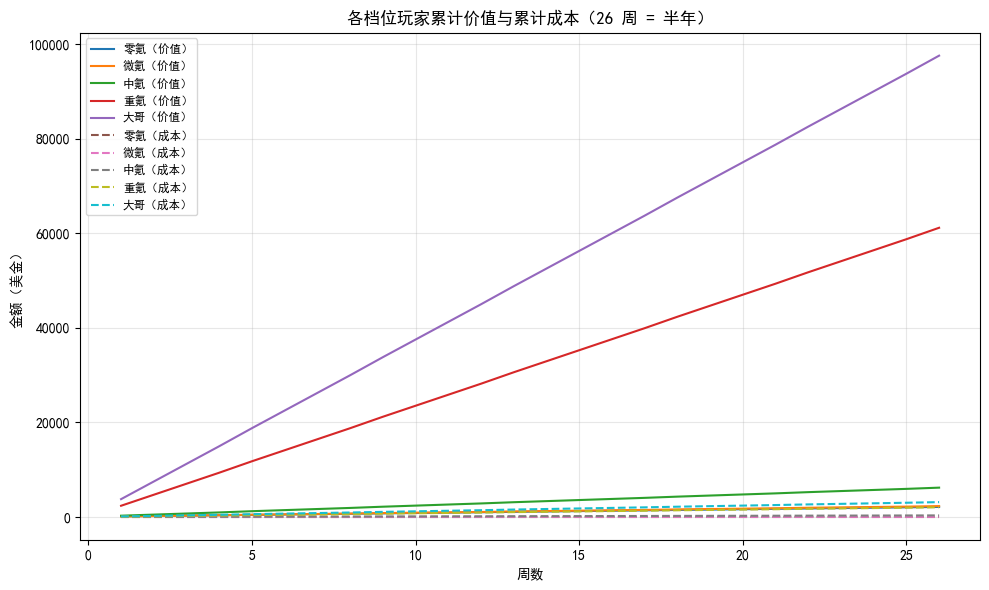

In [36]:
plt.figure(figsize=(10, 6))

# 绘制各档位的“累计价值”曲线（实线）
for tier, vals in data_value.items():
    plt.plot(week_numbers, vals, label=f"{tier}（价值）", linestyle='-')

# 绘制各档位的“累计成本”曲线（虚线）
for tier, vals in data_cost.items():
    plt.plot(week_numbers, vals, label=f"{tier}（成本）", linestyle='--')

plt.xlabel("周数")
plt.ylabel("金额（美金）")
plt.title("各档位玩家累计价值与累计成本（26 周 = 半年）")
plt.legend(loc="upper left", fontsize="small")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()